## Загрузка

**Загрузить файлы моделей model_v4_up.h5 и model_v4_down.h5 в '/content/...'**

In [ ]:
import importlib.util, sys, gdown

In [ ]:
url = 'https://storage.googleapis.com/aiu_bucket/data.zip'
output = 'data.zip' # Указываем имя файла, в который сохраняем файл
gdown.download(url, output, quiet=True) # Скачиваем файл по указанному URL

'data.zip'

In [ ]:
!unzip -q data.zip -d ''

## Основной блок

In [ ]:
import utils # Подключаем набор функций

**Загрузка данных**

In [ ]:
train_dataset, val_dataset = utils.getData() # Загружаем обучающий и проверочный датасет

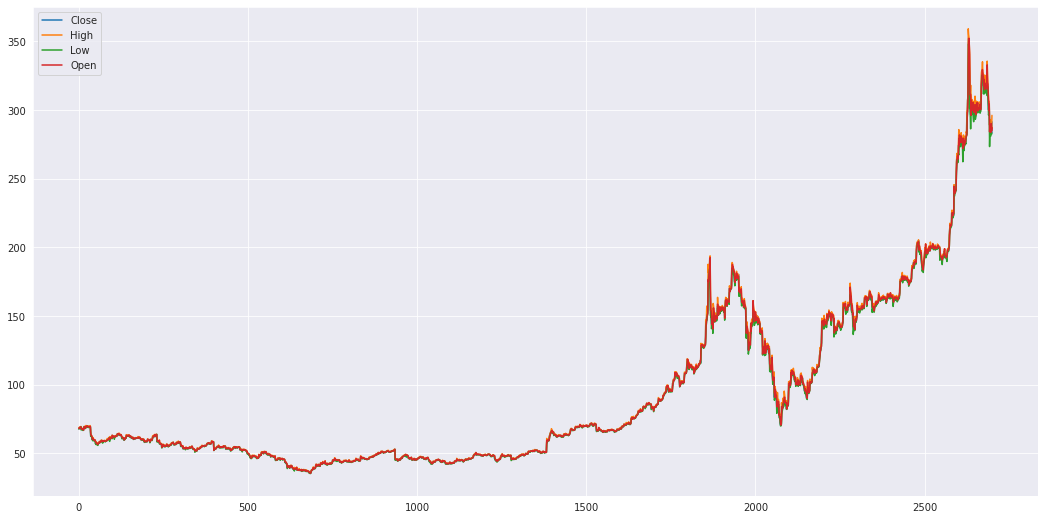

In [ ]:
utils.show_data(train_dataset, start=0, end=0, param=['Close','High','Low','Open']) # Визуализируем обучающий датасет

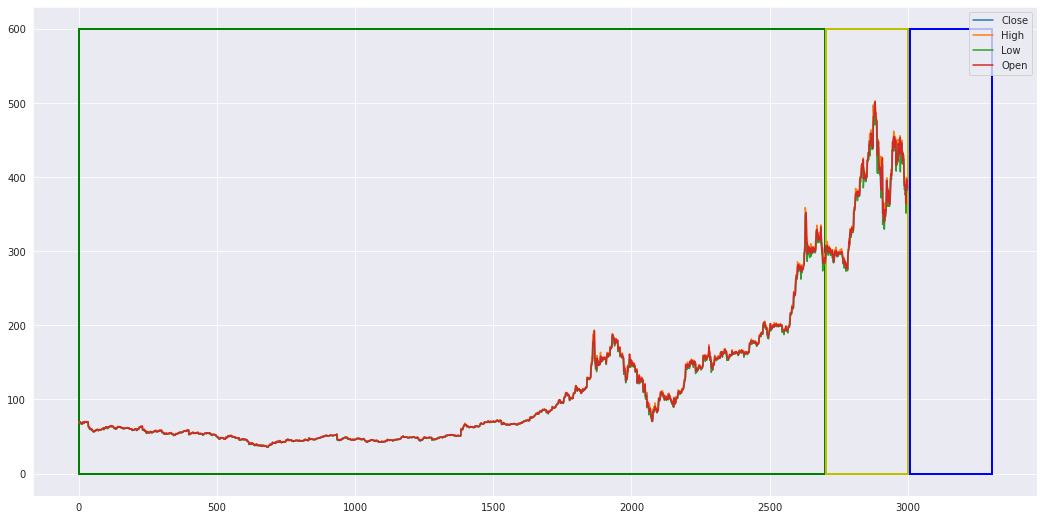

In [ ]:
utils.show_full_data(train_dataset, val_dataset,param=['Close','High','Low','Open'])

**Блок создания нейронной сети**

In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, LeakyReLU #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
import keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback,ReduceLROnPlateau,EarlyStopping
from IPython.display import clear_output
from keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.metrics import AUC
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix,roc_auc_score, roc_curve, precision_recall_fscore_support


# Рисовать графики сразу же
%matplotlib inline

**Добавить каналы**

In [ ]:
#функция добавления каналов данных
def add_chanels(data_enter,train):
  data = data_enter.copy(deep=True)
  pd.options.mode.chained_assignment = None
  col = data.columns

  # Get the difference in price from previous step
  
  data['Pct'] = data['Close'].pct_change()

  # Make the positive gains (up) and negative gains (down) Series
  data['up'], data['down'] = data['Pct'].copy(), data['Pct'].copy()
  data.loc[data['up'] < 0.02,'up']=0
  data.loc[data['up'] > 0,'up']=1
  data.loc[data['down'] > -0.02,'down']=0
  data.loc[data['down'] < 0,'down']=1
  #data['delta'] = data['Close'].diff()

  
  for i in range(col.shape[0]):                                                   #Для всех пар
    for j in range(i + 1 , col.shape[0]):                                         #Считаем
      data[col[i] + '-' + col[j]] = data[col[i]] - data[col[j]]                   #Разности
      data['|' + col[i] + '-' + col[j] + '|'] = abs(data[col[i]] - data[col[j]])  #Модули разностей
      data[col[i] + '*' + col[j]] = data[col[i]] * data[col[j]]                   #Произведения
  
  

  #Для каждого столбца 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME' считаем:
  for i in col:
    #data['Обратный ' + i] = 1 / (data[i] + 1e-3) #обратные значения. 1e-3 в формуле нужно, чтобы случайно не разделить на 0
    data['Производная от ' + i] = np.nan #Создаем пустой столбец
    data['Производная от ' + i][1:] = data[i][1:].reset_index(drop=True) - data[i][:-1].reset_index(drop=True) #При помощи срезов считаем первые производные .reset_index(drop=True) нужен для корректных подсчетов
    data['Вторая производная от ' + i] = np.nan #Создаем пустой столбец 
    data['Вторая производная от ' + i][2:] = data[i][2:].reset_index(drop=True) - 2 * data[i][1:-1].reset_index(drop=True) + data[i][:-2].reset_index(drop=True) #При помощи срезов считаем вторые производные 
    
    if i!='Volume':
      data['Отношения ' + i] = np.nan #Создаем пустой столбец 
      data['Отношения ' + i][1:] = data[i][1:].reset_index(drop=True)/data[i][:-1].reset_index(drop=True) #отношение
      data['Log Отношения ' + i] = np.nan #Создаем пустой столбец 
      data['Log Отношения ' + i][1:] = np.log(data[i][1:].reset_index(drop=True)/data[i][:-1].reset_index(drop=True)) #log отношения 
  
  
  
  
  '''
  for i in range(10,26,5):
    data['RSI'+ str(i)] = 100.0 - (100.0 / (1.0 + data['up'].rolling(i).mean()/data['down'].abs().rolling(i).mean()))
  
  for i in range(5,26,5):
    data['MA'+ str(i)] = data['Close'].rolling(i).mean()

  for i in range(15,56,10):
    data['MA'+ str(i)] = data['Close'].rolling(i).mean()
  '''

  data = data.iloc[2:]
  #print(data.iloc[:20,:10])
  #data = np.array(data)


  return data

In [ ]:
#Добавляем каналы к исходному датафрейму
ext_train_dataset = add_chanels(train_dataset, train=True)
print(ext_train_dataset[ext_train_dataset['up']>0]['up'].count())
print(ext_train_dataset[ext_train_dataset['down']>0]['down'].count())
ext_train_dataset = np.array(ext_train_dataset)
print(ext_train_dataset.shape)


126
105
(2698, 56)


In [ ]:
#функция добавления глубины просмотра

#numofpoints - число точек, выбираемых с определенным шагом
#stepamongpoints - шаг, с которым выбираются точки 
#continuouslinelen - длина выборки, выбираемая "как есть"
#stride - шаг, с которым предсказываем

def ourTimeseriesGenerator(xTrain, yTrain, numofpoints, stepamongpoints, continuouslinelen , stride):
  x, y, = [], [] #Создаем списки для x и для y

  index = 0 #Начальный индекс задаем равный нулю 

  #считаем длину вектора, который мы захватим при раскусывании на numofpoints точек с шагом stepamongpoints
  periodlinelen = stepamongpoints * (numofpoints - 1) + 1 

  #считаем длину вектора, который мы захватим при раскусывании на numofpoints точек с шагом stepamongpoints и на участок с непрерывной линией
  line = periodlinelen + continuouslinelen

  while index + line + stride < xTrain.shape[0]: # Определеям, позволяет ли длина выборки раскусить данные 

    endperiodline = index + periodlinelen #Вычисляем индекс, где закончится раскусывание с шагом
    periodline = xTrain[index:endperiodline:stepamongpoints] #Раскусываем с шагом
    continuousline = xTrain[endperiodline: endperiodline + continuouslinelen] #Берем непрерывную линию

    X = np.concatenate([periodline, continuousline])

    
    xScaler = StandardScaler()  #MinMaxScaler
    xScaler.fit(X)
    X = xScaler.transform(X)
    

    x.append(X) #Объединяем две линии и добавляем в x
    y.append(yTrain[endperiodline + continuouslinelen - 1 + stride]) #Элемент, следующий после выборки x через шаг stride отправляем в y
    index += 1 #Увеличиваем индекс на 1

  x = np.array(x) #Преобразуем в numpy
  y = np.array(y) #Преобразуем в numpy
  
  return x, y, xScaler #Возвращаем x и y


Формируем данные для обучения

In [ ]:
#формируем данные
valLen = 500                  #Используем ... записей для проверки #400
numofpoints = 1               # 1
stepamongpoints = 1            # 1
continuouslinelen = 50       #используем ...записей  #50
stride = 1
stepsForward = 1        #для прогноза на stepsForward шагов вперед

trainLen = ext_train_dataset.shape[0] - valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки
if stepsForward <2:
  xTrain, xTest = ext_train_dataset[:trainLen], ext_train_dataset[trainLen + stepamongpoints * (numofpoints - 1) + 2:]
else:
  xTrain, xTest = ext_train_dataset[:trainLen-stepsForward], ext_train_dataset[trainLen + stepamongpoints * (numofpoints - 1) + 2:-stepsForward+1]


#Масштабируем данные (отдельно для X и Y)
'''
xScaler = StandardScaler()  #MinMaxScaler
xScaler.fit(xTrain[-1000:])
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)
'''

if stepsForward <2:
  '''
  yTrainUp,yTestUp = np.reshape(ext_train_dataset[:trainLen,6],(-1,1)), np.reshape(ext_train_dataset[trainLen + stepamongpoints * (numofpoints - 1) + 2:,6],(-1,1))
  yTrainDown,yTestDown = np.reshape(ext_train_dataset[:trainLen,7],(-1,1)), np.reshape(ext_train_dataset[trainLen + stepamongpoints * (numofpoints - 1) + 2:,7],(-1,1))
  '''
  yTrainUp,yTestUp = ext_train_dataset[:trainLen,6], ext_train_dataset[trainLen + stepamongpoints * (numofpoints - 1) + 2:,6]
  yTrainDown,yTestDown = ext_train_dataset[:trainLen,7], ext_train_dataset[trainLen + stepamongpoints * (numofpoints - 1) + 2:,7]
else:
  yTrainUp = np.array([ext_train_dataset[:trainLen,6][i:i+stepsForward] for i in range(trainLen-stepsForward)])
  yTestUp = np.array([ext_train_dataset[trainLen + stepamongpoints * (numofpoints - 1) + 2:,6][i:i+stepsForward] for i in range(valLen- stepamongpoints * (numofpoints - 1)-stepsForward-1)])
  yTrainDown = np.array([ext_train_dataset[:trainLen,7][i:i+stepsForward] for i in range(trainLen-stepsForward)])
  yTestDown = np.array([ext_train_dataset[trainLen + stepamongpoints * (numofpoints - 1) + 2:,7][i:i+stepsForward] for i in range(valLen- stepamongpoints * (numofpoints - 1)-stepsForward-1)])


xTrainFinal, yTrainFinalUp, xScaler = ourTimeseriesGenerator(xTrain, yTrainUp, numofpoints, stepamongpoints, continuouslinelen , stride)
xTrainFinal, yTrainFinalDown, xScaler = ourTimeseriesGenerator(xTrain, yTrainDown, numofpoints, stepamongpoints, continuouslinelen , stride)
xTestFinal, yTestFinalUp, xScaler = ourTimeseriesGenerator(xTest, yTestUp, numofpoints, stepamongpoints, continuouslinelen , stride)
xTestFinal, yTestFinalDown, xScaler = ourTimeseriesGenerator(xTest, yTestDown, numofpoints, stepamongpoints, continuouslinelen , stride)

xTrainFinal_1 = xTrainFinal[:,:,:5]
xTestFinal_1 = xTestFinal [:,:,:5]

xTrainFinal_2 = xTrainFinal #[:,:,5:]
xTestFinal_2 = xTestFinal #[:,:,5:]



print(xTrain.shape)
print(yTrainUp.shape)
print(yTrainDown.shape)
print(xTest.shape)
print(yTestUp.shape)
print(yTestDown.shape)
print(xTrainFinal_1.shape)
print(xTrainFinal_2.shape)
print(yTrainFinalUp.shape)
print(yTrainFinalDown.shape)
print(xTestFinal_1.shape)
print(xTestFinal_2.shape)
print(yTestFinalUp.shape)
print(yTestFinalDown.shape)


(2198, 56)
(2198,)
(2198,)
(498, 56)
(498,)
(498,)
(2146, 51, 5)
(2146, 51, 56)
(2146,)
(2146,)
(446, 51, 5)
(446, 51, 56)
(446,)
(446,)


In [ ]:
def create_model_D (yTrainFinal):
  model = Sequential()
  
  #model.add(LSTM(5,input_shape = xTrainFinal[0].shape, return_sequences=True))

  model.add(Conv1D(500,3,input_shape = xTrainFinal[0].shape, padding='same', activation = 'relu'))  #
  model.add(Conv1D(100,3, padding='same', activation = 'relu'))
  #model.add(Conv1D(25,3, padding='same', activation = 'relu'))
  #model.add(GlobalMaxPooling1D())

  model.add(Flatten())

  model.add(Dense(120, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  #model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  #model.add(Dropout(0.2))

  model.add(Dense(1, activation='sigmoid'))


  return model

In [ ]:
#callback auc

def on_epoch_end_auc(epoch, logs):
  clear_output(wait=True)
   #сохраняем модель с лучшей точностью
  if logs['val_auc']>=best_acc[0]:
    best_acc[0] = logs['val_auc']
  print('best_auc',best_acc[0])
  print('current_auc',logs['auc'])
  print('current_val_auc',logs['val_auc'])
  print('epoch',epoch)

save_weight_auc = LambdaCallback(on_epoch_end=on_epoch_end_auc)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                              patience=20, min_lr=0.000001, verbose=1, mode="max" )
early_stop = EarlyStopping(
    monitor='val_auc', min_delta=0, patience=500, verbose=1,
    mode='max', baseline=None, restore_best_weights=True)

# Создаем модель для лонга

In [ ]:
modelUp=create_model_D(yTrainFinalUp)
best_acc=[] #список для хранения лучшей точности
best_acc.append(0)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(modelUp, show_shapes=True, show_layer_names=True)

best_auc 0.7477365732192993
current_auc 1.0
current_val_auc 0.5682395100593567
epoch 862
Restoring model weights from the end of the best epoch.
Epoch 00863: early stopping



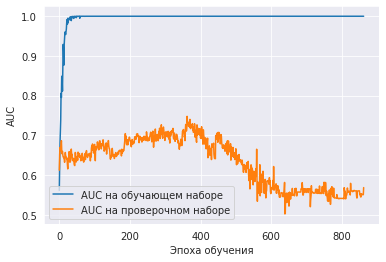

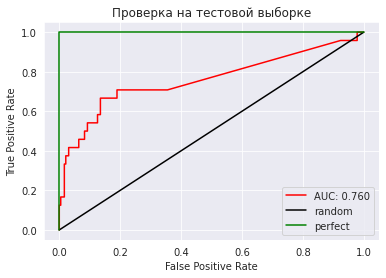

In [ ]:
#первый запуск обучения модели

#Компилируем
modelUp.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-5), metrics=[AUC(name="auc")])

#Запускаем обучение
history = modelUp.fit(xTrainFinal_2,
                     yTrainFinalUp, 
                    epochs=1000,
                    batch_size=40, 
                    verbose=0, 
                    validation_split=0.2,
                    callbacks=[save_weight_auc,early_stop]
                    ) #validation_data = ([xTestFinal_1,xTestFinal_2], yTestFinalUp),  [xTrainFinal_1,xTrainFinal_2]

#modelUp.load_weights ('/content/model_weights')
modelUp.save('/content/model_v4_up.h5')



#Выводим графики
print()
plt.plot(history.history['auc'], 
         label='AUC на обучающем наборе')
plt.plot(history.history['val_auc'], 
         label='AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Проверяем на тестовой выборке и выводим график ROC_AUC
#modelUp.load_weights('/content/model_weights')
pred = modelUp.predict(xTestFinal) #[xTestFinal_1,xTestFinal_2]

roc_auc = roc_auc_score(yTestFinalUp, pred)

fpr, tpr, thresholds = roc_curve(yTestFinalUp, pred)
print()
plt.plot(fpr, tpr,'r-',label = 'AUC: %.3f'%roc_auc)
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect',)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Проверка на тестовой выборке')
plt.show()

best_auc 0.7477365732192993
current_auc 1.0
current_val_auc 0.6573284268379211
epoch 752
Restoring model weights from the end of the best epoch.
Epoch 00753: early stopping



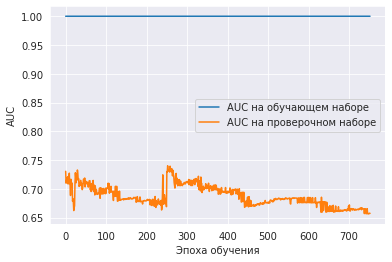

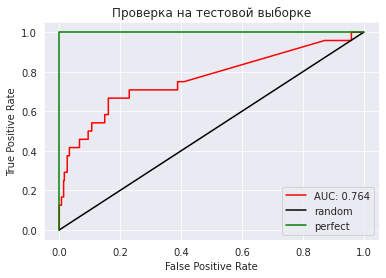

In [ ]:
#Дообучаем модель
#Компилируем
#modelUp.load_weights ('/content/model_weights')
modelUp.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-5), metrics=[AUC(name="auc")])

history = modelUp.fit(xTrainFinal,
                     yTrainFinalUp, 
                    epochs=1000,
                    batch_size=40, 
                    verbose=0, 
                    validation_split=0.2,
                    callbacks=[save_weight_auc,reduce_lr,early_stop]
                    )   #[xTrainFinal_1,xTrainFinal_2]
#modelUp.load_weights ('/content/model_weights')
modelUp.save('/content/model_v4_up.h5')

#Выводим графики
print()
plt.plot(history.history['auc'], 
         label='AUC на обучающем наборе')
plt.plot(history.history['val_auc'], 
         label='AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Проверяем на тестовой выборке и выводим график ROC_AUC
#modelUp.load_weights('/content/model_weights')
pred = modelUp.predict(xTestFinal) #[xTestFinal_1,xTestFinal_2]

roc_auc = roc_auc_score(yTestFinalUp, pred)

fpr, tpr, thresholds = roc_curve(yTestFinalUp, pred)
print()
plt.plot(fpr, tpr,'r-',label = 'AUC: %.3f'%roc_auc)
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect',)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Проверка на тестовой выборке')
plt.show()

In [ ]:
y_pred=[]

thresh=0.5
for p in pred:
  p=np.round(p,1)
  if p<thresh:
    y_=(0)
  #if p==thresh:
   # y_=(0.5)
  if p>=thresh:
    y_=(1)
  y_pred.append(y_)


y_pred=np.array(y_pred)
tn, fp, fn, tp = confusion_matrix(yTestFinalUp, y_pred).ravel()
print(tn, fp, fn, tp)

print(classification_report(yTestFinalUp, y_pred))

409 13 15 9
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       422
         1.0       0.41      0.38      0.39        24

    accuracy                           0.94       446
   macro avg       0.69      0.67      0.68       446
weighted avg       0.93      0.94      0.94       446



# Создаем модель для шорта

In [ ]:
modelDown=create_model_D(yTrainFinalDown)
best_acc=[] #список для хранения лучшей точности
best_acc.append(0)

best_auc 0.6383344531059265
current_auc 0.9999475479125977
current_val_auc 0.6115838289260864
epoch 999



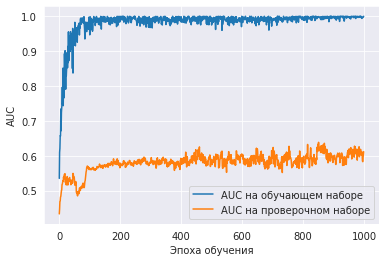

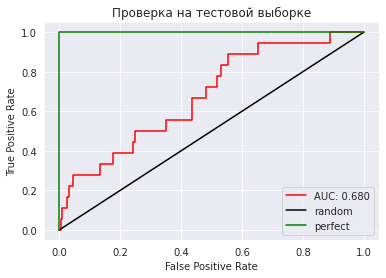

In [ ]:
#первый запуск обучения модели

#Компилируем
modelDown.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-5), metrics=[AUC(name="auc")])

#Запускаем обучение
history = modelDown.fit(xTrainFinal_2,
                     yTrainFinalDown, 
                    epochs=1000, 
                    batch_size=40,
                    verbose=0, 
                    validation_split=0.2,
                    callbacks=[save_weight_auc,early_stop]
                    ) 

modelDown.save('/content/model_v4_down.h5')

#Выводим графики
print()
plt.plot(history.history['auc'], 
         label='AUC на обучающем наборе')
plt.plot(history.history['val_auc'], 
         label='AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Проверяем на тестовой выборке и выводим график ROC_AUC

pred = modelDown.predict(xTestFinal) 

roc_auc = roc_auc_score(yTestFinalDown, pred)

fpr, tpr, thresholds = roc_curve(yTestFinalDown, pred)
print()
plt.plot(fpr, tpr,'r-',label = 'AUC: %.3f'%roc_auc)
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect',)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Проверка на тестовой выборке')
plt.show()

best_auc 0.7477365732192993
current_auc 0.998985767364502
current_val_auc 0.6047666072845459
epoch 999



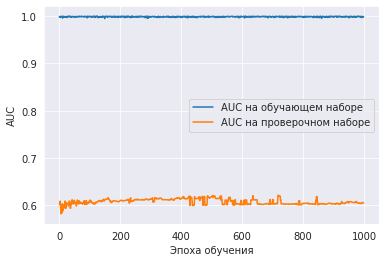

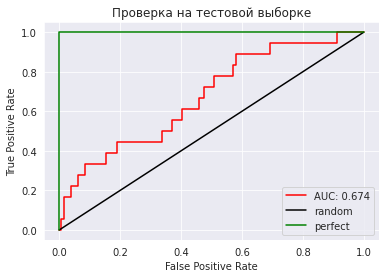

In [ ]:
#Дообучаем модель
#Компилируем
#modelDown.load_weights ('/content/model_weights')
modelDown.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-5), metrics=[AUC(name="auc")])

history = modelDown.fit(xTrainFinal,
                     yTrainFinalDown, 
                    epochs=1000, 
                    batch_size = 400,
                    verbose=0, 
                    validation_split=0.2,
                    callbacks=[save_weight_auc,reduce_lr,early_stop]
                    )     

modelDown.save('/content/model_v4_down.h5')

#Выводим графики
print()
plt.plot(history.history['auc'], 
         label='AUC на обучающем наборе')
plt.plot(history.history['val_auc'], 
         label='AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Проверяем на тестовой выборке и выводим график ROC_AUC

pred = modelDown.predict(xTestFinal) 

roc_auc = roc_auc_score(yTestFinalDown, pred)

fpr, tpr, thresholds = roc_curve(yTestFinalDown, pred)
print()
plt.plot(fpr, tpr,'r-',label = 'AUC: %.3f'%roc_auc)
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect',)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Проверка на тестовой выборке')
plt.show()

In [ ]:
y_pred=[]

thresh=0.5

for p in pred:
  p=np.round(p,1)
  if p<thresh:
    y_=(0)
  #if p==thresh:
   # y_=(0.5)
  if p>=thresh:
    y_=(1)
  y_pred.append(y_)


y_pred=np.array(y_pred)
tn, fp, fn, tp = confusion_matrix(yTestFinalDown, y_pred).ravel()
print(tn, fp, fn, tp)

print(classification_report(yTestFinalDown, y_pred))

426 2 17 1
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       428
         1.0       0.33      0.06      0.10        18

    accuracy                           0.96       446
   macro avg       0.65      0.53      0.54       446
weighted avg       0.94      0.96      0.94       446



**Функции для стратегии и теста**

In [ ]:
#функция для подготовки массива входных данных 
def predTimeseriesGenerator(df, numofpoints, stepamongpoints, continuouslinelen, xScaler):
  x = []
  totallen = df.shape[0]
  #print('totallen',totallen)
  periodlinelen = stepamongpoints * (numofpoints - 1) + 1
  line = periodlinelen + continuouslinelen
  #print('line',line)
  index=totallen-line
  #print('index',index)
  endperiodline = index + periodlinelen #Вычисляем индекс, где закончится раскусывание с шагом
  periodline = df[index:endperiodline:stepamongpoints] #Раскусываем с шагом
  continuousline = df[endperiodline: endperiodline + continuouslinelen] #Берем непрерывную линию

  X = np.concatenate([periodline, continuousline])
  
  X = xScaler.transform(X)
  

  x.append(X) #Объединяем две линии и добавляем в x
  x = np.array(x)
  #print(df.shape)
  #print(x.shape)
  #print('df',df[-1,:])
  #print('df',df[totallen-1:,:])
  #print('continuousline',continuousline[-1,:])
  #print('x',x[-1])
  
  return x

In [ ]:
#Функция прогноза
def getPred_result (model,xPred):
  pred_result = model.predict(xPred) #[:,:,5:]   [xPred[:,:,:5],xPred]
  return pred_result

In [ ]:
#Функция подготовки входных данных, прогноза цены и определения торгового решения
def traide(df,modelUp,modelDown,xScaler, numofpoints, stepamongpoints, continuouslinelen):
  ext_df = add_chanels(df,train=False) #добавляем каналы на вход
  #print(ext_df)

  ext_df = np.array(ext_df)
  #ext_df = xScaler.transform(ext_df) #масштабируем входные данные
  xPred = predTimeseriesGenerator(ext_df, numofpoints, stepamongpoints, continuouslinelen, xScaler) #формируем вектор со взглядом назад для подачи в сеть
 
  yPredUp = getPred_result(modelUp,xPred) #делаем прогноз движения цены вверх
  yPredDown = getPred_result(modelDown,xPred) #делаем прогноз движения цены вниз

  print()
  print('yPredUp: ', round(yPredUp[0][0],2))
  print('yPredDown: ', round(yPredDown[0][0],2))
  print()

  
  if yPredUp[0][0] > yPredDown[0][0]: # and yPredUp[0][0] >= 0.4 : # and (yPredUp[0][0] - yPredDown[0][0]) > 0.1 : #если по прогнозу цена выше предыдущей цены закрытия lastPrice (предыдущего прогноза lastPred)
    action =1 # покупаем 
  elif yPredUp[0][0] < yPredDown[0][0]: # and yPredDown[0][0] >= 0.4 : # and (yPredDown[0][0] -  yPredUp[0][0]) > 0.1 : #если по прогнозу цена ниже предыдущей цены закрытия lastPrice (предыдущего прогноза lastPred)
    action = 2 # продаем
  else:
    action =0

  return action

# **Блок тестирования модели**

**Загрузить файлы моделей model_v4_up.h5 и model_v4_down.h5 в '/content/...'**

In [ ]:
test_dataset = pd.read_csv('/content/test_dataset.csv')
test_dataset.drop('Date', inplace = True, axis = 1)


yPredUp:  0.02
yPredDown:  0.03

Продали в шорт
Цена: 400.0199890136719
Денег: 100000
Акций: 249.0
------------------------

yPredUp:  0.01
yPredDown:  0.0

Закрыли шорт
Цена: 406.7049865722656
Денег: 98335.43560791016
Результат сделки: -1664.5643920898438
Акций: 0
------------------------
Купили в лонг
Цена: 406.7049865722656
Денег: 98335.43560791016
Акций: 241.0
------------------------

yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.07
yPredDown:  0.0


yPredUp:  0.1
yPredDown:  0.0


yPredUp:  0.02
yPredDown:  0.0


yPredUp:  1.0
yPredDown:  0.26


yPredUp:  0.12
yPredDown:  0.0


yPredUp:  0.02
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.02
yPredDown:  0.0


yPredUp:  0.05
yPredDown:  0.0


yPredUp:  0.02
yPredDown:  0.0


yPredUp:  1.0
yPredDown:  1.0


yPredUp:  0.01
yPredDown:  0.31

Закрыли лонг
Цена: 416.20001220703125
Денег: 100623.73678588867
Результат сделки: 2288.3011779785156
Акций: 0
------------------------
Продали в шорт
Цена: 416.20001220703125
Дене

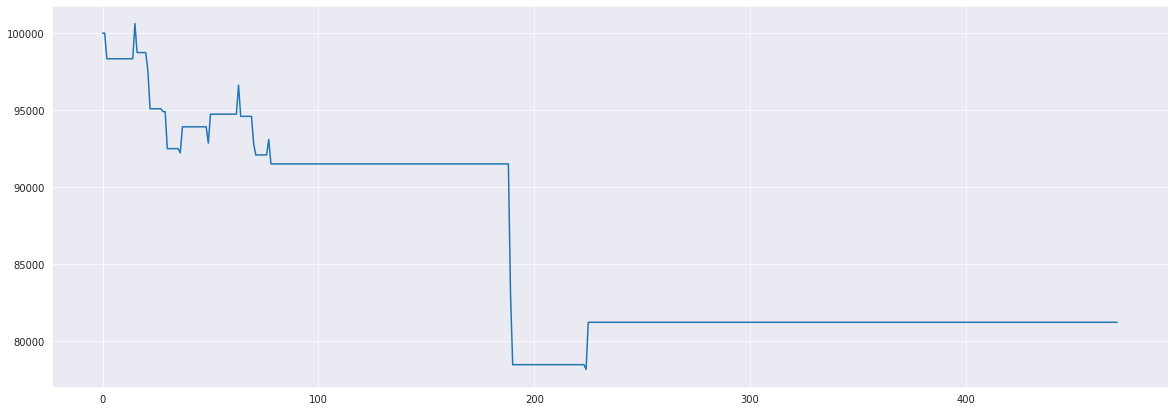

Максимальная просадка:  -21867.89 руб.
Максимальный убыток на сделку:  -8460.09 руб.
Максимальная прибыль на сделку:  3071.0 руб.
Всего сделок:  22
Прибыльных сделок:  6
Убыточных сделок:  15
Средняя прибыль на сделку:  1971.56 руб.
Средний убыток на сделку:  -2041.75 руб.
Мат ожидание на сделку:  -895.09 руб.


In [ ]:
# Ваша стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
dataset = train_dataset.append(val_dataset).reset_index(drop=True) # Объединяем обучающий и проверочный датасеты
money_history = [money] # Статистика капитала

lastPred=[]
pos=0
enter_price = 0
exit_price = 0
profit_history=[]
cnt_trades=0
negative_trades = []
positive_trades = []

modelUp = load_model('/content/model_v4_up.h5')
modelDown = load_model('/content/model_v4_down.h5')

#проверка работы
#test_dataset=val_dataset.copy()


# Проходим по всему тестовому датасету
for i in range(1, test_dataset.shape[0]+1):
  df = dataset.append(test_dataset[:i]).reset_index(drop=True) # Считываем очередное значение из тестового датасета
  '''
  Здесь должна быть Ваша стратегия
  '''
  action = traide(df,modelUp,modelDown,xScaler, numofpoints, stepamongpoints, continuouslinelen) # Получаем действие, которое будем совершать
  #lastPred.append(pred) 
  # Если это последнее значение тестовой выборки, не торгуем
  if i== val_dataset.shape[0]:
    action=0
    


  if pos ==0: #если нет открытой позиции
    if action == 1: #если сигнал на покупку, идем в лонг
      enter_price = df.iloc[-1]['Close'] # цена входа в позицию
      shares += money // df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество
      cnt_trades +=1
      pos = 1 #выставляем флаг лонга

      # Выводим статистическую информацию
      print('Купили в лонг')
      print('Цена:', df.iloc[-1]['Close'])
      print('Денег:', money)
      print('Акций:', shares)
      print('------------------------')

    elif action == 2: # если сигнал на продажу, то идем в шорт
      enter_price = df.iloc[-1]['Close'] # цена входа в позицию
      shares += money // df.iloc[-1]['Close'] # Продаем на все имеющиеся деньги акции (продаем целое количество)
      cnt_trades +=1
      pos = -1 #выставляем флаг шорта

      # Выводим статистическую информацию
      print('Продали в шорт')
      print('Цена:', df.iloc[-1]['Close'])
      print('Денег:', money)
      print('Акций:', shares)
      print('------------------------')

  elif pos ==1: # если открыт лонг
    if action == 2: # если сигнал на продажу, закрываем лонг (продаем все акции)
      exit_price = df.iloc[-1]['Close'] #цена выхода из позиции
      money += (exit_price-enter_price)*shares*pos
      
      #статистика
      profit_history.append((exit_price-enter_price)*shares*pos)
      if profit_history[-1] >0:
        positive_trades.append(profit_history[-1]) #добавляем сделку в прибыльные
      else:
        negative_trades.append(profit_history[-1])  #добавляем сделку в убыточные
    
      # Выводим статистическую информацию
      print('Закрыли лонг')
      print('Цена:', df.iloc[-1]['Close'])
      print('Денег:', money)
      print('Результат сделки:', (exit_price-enter_price)*shares*pos)
      shares = 0
      print('Акций:', shares)
      print('------------------------')  
      pos = 0

      if money > df.iloc[-1]['Close']: # если есть деньги хоть на однй акцию, идем в шорт
        enter_price = df.iloc[-1]['Close']
        shares += money // df.iloc[-1]['Close'] # Продаем на все имеющиеся деньги акции (продаем целое количество)
        cnt_trades +=1
        pos = -1 #выставляем флаг шорта

        # Выводим статистическую информацию
        print('Продали в шорт')
        print('Цена:', df.iloc[-1]['Close'])
        print('Денег:', money)
        print('Акций:', shares)
        print('------------------------')


  elif pos == -1: # если открыт шорт
    if action == 1: # если сигнал на покупку, закрываем лонг("откупаем" все акции)
      exit_price = df.iloc[-1]['Close'] #цена выхода из позиции
      money += (exit_price-enter_price)*shares*pos
      profit_history.append((exit_price-enter_price)*shares*pos)
      
      #статистика
      profit_history.append((exit_price-enter_price)*shares*pos)
      if profit_history[-1] >0:
        positive_trades.append(profit_history[-1]) #добавляем сделку в прибыльные
      else:
        negative_trades.append(profit_history[-1])  #добавляем сделку в убыточные

      # Выводим статистическую информацию
      print('Закрыли шорт')
      print('Цена:', df.iloc[-1]['Close'])
      print('Денег:', money)
      print('Результат сделки:', (exit_price-enter_price)*shares*pos)
      shares = 0
      print('Акций:', shares)
      print('------------------------')
      pos = 0

      if money > df.iloc[-1]['Close']: # если есть деньги хоть на одну акцию, идем в лонг
        enter_price = df.iloc[-1]['Close']
        shares += money // df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество)
        cnt_trades +=1
        pos = 1 #выставляем флаг лонга

        # Выводим статистическую информацию
        print('Купили в лонг')
        print('Цена:', df.iloc[-1]['Close'])
        print('Денег:', money)
        print('Акций:', shares)
        print('------------------------')

  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег

# Выводим статистику изменения капитала
plt.figure(figsize=(20,7))
plt.plot(money_history)
plt.show()


print('Максимальная просадка: ', round(-(100000 - min(money_history)),2), 'руб.')
print('Максимальный убыток на сделку: ', round(min(profit_history),2), 'руб.')
print('Максимальная прибыль на сделку: ', round(max(profit_history),2), 'руб.')
print('Всего сделок: ', cnt_trades)
print('Прибыльных сделок: ', len(positive_trades))
print('Убыточных сделок: ', len(negative_trades))
print('Средняя прибыль на сделку: ', round(sum(positive_trades)/len(positive_trades),2), 'руб.')
print('Средний убыток на сделку: ', round(sum(negative_trades)/len(negative_trades),2), 'руб.')
print('Мат ожидание на сделку: ', round((sum(negative_trades)/len(negative_trades))*(len(negative_trades)/(cnt_trades-1)) + (sum(positive_trades)/len(positive_trades))*(len(positive_trades)/(cnt_trades-1)),2), 'руб.')


In [ ]:
print('Финальный результат: ', round(money,2), 'руб.')

Финальный результат:  81203.11 руб.


# **Проверка стратегии на Val_Dataset**

**Стратегия только в лонг**


yPredUp:  0.01
yPredDown:  0.0

Купили
Цена: 285.96063232421875
Денег: 199.73931884765625
Акций: 349.0
------------------------

yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.08
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.02
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.68
yPredDown:  0.01


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.01

Продали
Цена: 300.14898681640625
Денег: 104951.73571777344
Акций: 0
------------------------

yPredUp:  0.01
yPredDown:  0.01

Продали
Цена: 300.4290

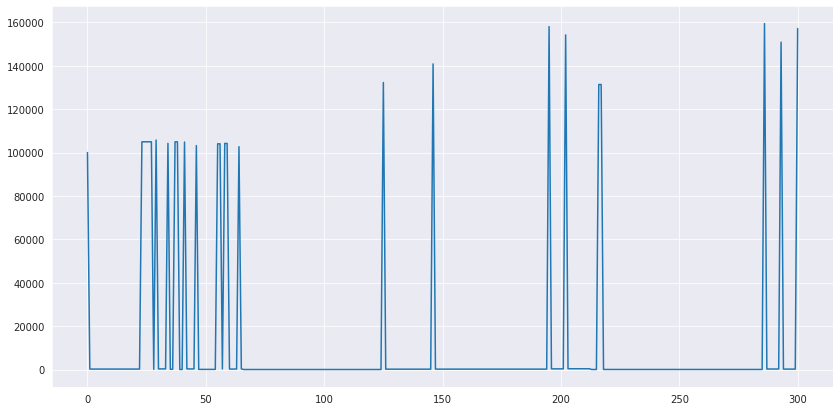

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ваша стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
dataset = train_dataset # В dataset записываем обучающий набор
money_history = [money] # Статистика капитала
lastPred=[]

modelUp = load_model('/content/model_v4_up.h5')
modelDown = load_model('/content/model_v4_down.h5')

# Проходим по всему проверочному набору
for i in range(1, val_dataset.shape[0]+1):
  df = train_dataset.append(val_dataset[:i]).reset_index(drop=True) # Считываем очередное значение из проверочного набора
  
  action = traide(df,modelUp,modelDown,xScaler, numofpoints, stepamongpoints, continuouslinelen,) # Получаем действие, которое будем совершать
  #lastPred.append(pred)
  # Если это последнее значение тестовой выборки
  if i== val_dataset.shape[0]:
    action=0
    if shares!=0:
      money += shares * df.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
      shares = 0 # Количество акцией сбрасываем в 0
    

    # Выводим статистическую информацию
    print('Продали')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')


  # Если должны покупать и есть деньги хотя бы на одну акцию
  if action==1 and money > df.iloc[-1]['Close']:
    shares += money // df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
    money = money % df.iloc[-1]['Close'] # Считаем сколько осталось денег после покупки акций
    
    # Выводим статистическую информацию
    print('Купили')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')

  # Если должны продавать
  elif action==2:
    money += shares * df.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
    shares = 0 # Количество акцией сбрасываем в 0
    
    # Выводим статистическую информацию
    print('Продали')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')  
  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег

# Выводим статистику изменения капитала
plt.figure(figsize=(14,7))
plt.plot(money_history)
plt.show()


In [ ]:
print('Финальный результат: ', round(money,2), 'руб.')

Финальный результат:  157183.92 руб.


**Стратегия с Шорт**


yPredUp:  0.01
yPredDown:  0.0

Купили в лонг
Цена: 285.96063232421875
Денег: 100000
Акций: 349.0
------------------------

yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.08
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.02
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.68
yPredDown:  0.01


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.01
yPredDown:  0.0


yPredUp:  0.0
yPredDown:  0.01

Закрыли лонг
Цена: 300.14898681640625
Денег: 104951.73571777344
Результат сделки: 4951.7357177734375
Акций: 0
------------------------
Продали в шорт
Цена

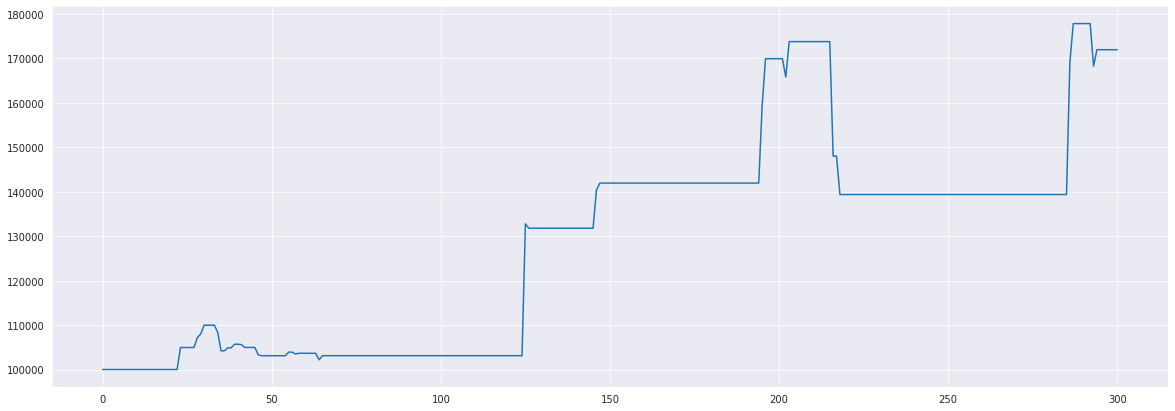

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ваша стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
dataset = train_dataset # В dataset записываем обучающий набор
money_history = [money] # Статистика капитала
lastPred=[]
pos=0
enter_price = 0
exit_price = 0
profit_history=[]
cnt_trades=0
negative_trades = []
positive_trades = []

modelUp = load_model('/content/model_v4_up.h5')
modelDown = load_model('/content/model_v4_down.h5')

# Проходим по всему проверочному набору
for i in range(1, val_dataset.shape[0]+1):
  df = train_dataset.append(val_dataset[:i]).reset_index(drop=True) # Считываем очередное значение из проверочного набора
  
  action = traide(df,modelUp,modelDown,xScaler, numofpoints, stepamongpoints, continuouslinelen) # Получаем действие, которое будем совершать
  #lastPred.append(pred) 
  # Если это последнее значение тестовой выборки, не торгуем
  if i== val_dataset.shape[0]:
    action=0
    


  if pos ==0: #если нет открытой позиции
    if action == 1: #если сигнал на покупку, идем в лонг
      enter_price = df.iloc[-1]['Close'] # цена входа в позицию
      shares += money // df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество
      cnt_trades +=1
      pos = 1 #выставляем флаг лонга

      # Выводим статистическую информацию
      print('Купили в лонг')
      print('Цена:', df.iloc[-1]['Close'])
      print('Денег:', money)
      print('Акций:', shares)
      print('------------------------')

    elif action == 2: # если сигнал на продажу, то идем в шорт
      enter_price = df.iloc[-1]['Close'] # цена входа в позицию
      shares += money // df.iloc[-1]['Close'] # Продаем на все имеющиеся деньги акции (продаем целое количество)
      cnt_trades +=1
      pos = -1 #выставляем флаг шорта

      # Выводим статистическую информацию
      print('Продали в шорт')
      print('Цена:', df.iloc[-1]['Close'])
      print('Денег:', money)
      print('Акций:', shares)
      print('------------------------')

  elif pos ==1: # если открыт лонг
    if action == 2: # если сигнал на продажу, закрываем лонг (продаем все акции)
      exit_price = df.iloc[-1]['Close'] #цена выхода из позиции
      money += (exit_price-enter_price)*shares*pos
      
      #статистика
      profit_history.append((exit_price-enter_price)*shares*pos)
      if profit_history[-1] >0:
        positive_trades.append(profit_history[-1]) #добавляем сделку в прибыльные
      else:
        negative_trades.append(profit_history[-1])  #добавляем сделку в убыточные
    
      # Выводим статистическую информацию
      print('Закрыли лонг')
      print('Цена:', df.iloc[-1]['Close'])
      print('Денег:', money)
      print('Результат сделки:', (exit_price-enter_price)*shares*pos)
      shares = 0
      print('Акций:', shares)
      print('------------------------')  
      pos = 0

      if money > df.iloc[-1]['Close']: # если есть деньги хоть на однй акцию, идем в шорт
        enter_price = df.iloc[-1]['Close']
        shares += money // df.iloc[-1]['Close'] # Продаем на все имеющиеся деньги акции (продаем целое количество)
        cnt_trades +=1
        pos = -1 #выставляем флаг шорта

        # Выводим статистическую информацию
        print('Продали в шорт')
        print('Цена:', df.iloc[-1]['Close'])
        print('Денег:', money)
        print('Акций:', shares)
        print('------------------------')


  elif pos == -1: # если открыт шорт
    if action == 1: # если сигнал на покупку, закрываем лонг("откупаем" все акции)
      exit_price = df.iloc[-1]['Close'] #цена выхода из позиции
      money += (exit_price-enter_price)*shares*pos
      profit_history.append((exit_price-enter_price)*shares*pos)
      
      #статистика
      profit_history.append((exit_price-enter_price)*shares*pos)
      if profit_history[-1] >0:
        positive_trades.append(profit_history[-1]) #добавляем сделку в прибыльные
      else:
        negative_trades.append(profit_history[-1])  #добавляем сделку в убыточные

      # Выводим статистическую информацию
      print('Закрыли шорт')
      print('Цена:', df.iloc[-1]['Close'])
      print('Денег:', money)
      print('Результат сделки:', (exit_price-enter_price)*shares*pos)
      shares = 0
      print('Акций:', shares)
      print('------------------------')
      pos = 0

      if money > df.iloc[-1]['Close']: # если есть деньги хоть на одну акцию, идем в лонг
        enter_price = df.iloc[-1]['Close']
        shares += money // df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество)
        cnt_trades +=1
        pos = 1 #выставляем флаг лонга

        # Выводим статистическую информацию
        print('Купили в лонг')
        print('Цена:', df.iloc[-1]['Close'])
        print('Денег:', money)
        print('Акций:', shares)
        print('------------------------')

  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег

# Выводим статистику изменения капитала
plt.figure(figsize=(20,7))
plt.plot(money_history)
plt.show()


In [ ]:

print('Максимальная просадка: ', round(-(100000 - min(money_history)),2), 'руб.')
print('Максимальный убыток на сделку: ', round(min(profit_history),2), 'руб.')
print('Максимальная прибыль на сделку: ', round(max(profit_history),2), 'руб.')
print('Всего сделок: ', cnt_trades)
print('Прибыльных сделок: ', len(positive_trades))
print('Убыточных сделок: ', len(negative_trades))
print('Средняя прибыль на сделку: ', round(sum(positive_trades)/len(positive_trades),2), 'руб.')
print('Средний убыток на сделку: ', round(sum(negative_trades)/len(negative_trades),2), 'руб.')
print('Мат ожидание на сделку: ', round((sum(negative_trades)/len(negative_trades))*(len(negative_trades)/(cnt_trades-1)) + (sum(positive_trades)/len(positive_trades))*(len(positive_trades)/(cnt_trades-1)),2), 'руб.')

Максимальная просадка:  0 руб.
Максимальный убыток на сделку:  -25760.0 руб.
Максимальная прибыль на сделку:  29722.04 руб.
Всего сделок:  33
Прибыльных сделок:  18
Убыточных сделок:  14
Средняя прибыль на сделку:  7295.01 руб.
Средний убыток на сделку:  -4240.68 руб.
Мат ожидание на сделку:  2248.14 руб.


In [ ]:
print('Финальный результат: ', round(money,2), 'руб.')

Финальный результат:  171940.59 руб.
